In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
from scipy import interpolate

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # changes per computer
#import magaoxFunctions as mf
import psd_functions as psd
import zernike as zern
import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 15/05/2020 10:02:08


In [5]:
opt_parms = { 'ovs': 4096,
             'surf_units': u.micron,
             'ca': 75,
             'ring_width': 5}

parent_dir = '/home/jhen/XWCL/code/CACTI/'
data_folder = parent_dir + 'zygo_data/OAP_coated/'
test_oap =  'A'

# open the file mask to get header content
mask_hdr = fits.open(data_folder+'oap{0}_{1}CA_mask.fits'.format(test_oap, opt_parms['ca']))[0].header

# calculate the difference for reducing the clear aperture
d_new = (12*u.mm).to(u.m)
npix_diam_new = int(d_new/(mask_hdr['latres']*u.m))
if (npix_diam_new % 2) != 0:
    resize_diff = mask_hdr['naxis1'] - npix_diam_new - 1
else:
    resize_diff = mask_hdr['naxis1'] - npix_diam_new
    
# open each optic, but resize it down and save it
oap_labels =  ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')

for surface_name in oap_labels:
    # call in the file
    fileloc=data_folder+'oap{0}_{1}CA'.format(surface_name, opt_parms['ca'])
    surf, mask, sp = dfx.open_fits(filename=fileloc, diam_ca100=50*u.mm)
    
    # undersize the matrix equally
    surf, mask = dfx.mat_reduce(data=surf, mask=mask, side_reduce=resize_diff)
    if mask.shape[0] % 2 != 0: # this is a bug in my code that I can't figure out how to fix
        surf, mask = dfx.mat_reduce(data=surf, mask=mask, side_reduce=1)
    
    latres = sp['value'][sp['label'].index('latres')]
    diam = (latres * mask.shape[0]*u.pix).to(u.mm)
    clear_ap = diam / sp['value'][sp['label'].index('diam_100')] * 100
        
    # write to file
    new_filename = 'oap{0}_{1}CA'.format(surface_name, int(clear_ap))
    dfx.write_fits(surface=surf, mask=mask, surf_parms=sp, filename=data_folder+new_filename)
    print('n{0:5} | diameter: {1:.3f} | clear ap: {2:.2f}% | shape: {3} | name: {4}'.format(surface_name, diam, clear_ap, mask.shape, new_filename))

nA     | diameter: 12.070 mm | clear ap: 24.14% | shape: (72, 72) | name: oapA_24CA
nB     | diameter: 12.070 mm | clear ap: 24.14% | shape: (72, 72) | name: oapB_24CA
nC     | diameter: 12.070 mm | clear ap: 24.14% | shape: (72, 72) | name: oapC_24CA
nD     | diameter: 12.070 mm | clear ap: 24.14% | shape: (72, 72) | name: oapD_24CA
nE     | diameter: 12.070 mm | clear ap: 24.14% | shape: (72, 72) | name: oapE_24CA
nF     | diameter: 12.070 mm | clear ap: 24.14% | shape: (72, 72) | name: oapF_24CA
nG     | diameter: 12.070 mm | clear ap: 24.14% | shape: (72, 72) | name: oapG_24CA
nH     | diameter: 12.070 mm | clear ap: 24.14% | shape: (72, 72) | name: oapH_24CA


In [6]:
new_parms = { 'ovs': 4096,
             'surf_units': u.micron,
             'ca': 24,
             'ring_width': 5}

parent_dir = '/home/jhen/XWCL/code/CACTI/'
data_folder = parent_dir + 'zygo_data/OAP_coated/'
oap_labels =  ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')
oap=[]

for surface_name in oap_labels:
    n_step = 'OAP {0}'.format(surface_name)
    file_loc=data_folder+'oap{0}_{1}CA'.format(surface_name, new_parms['ca'])
    # create the object
    opt = psd.surfPSD(surf_name = n_step)
    opt.open_surf(fileloc=file_loc+'_surf.fits', surf_units = new_parms['surf_units'])
    opt.open_mask(fileloc=file_loc+'_mask.fits')
    opt.calc_psd(oversamp = new_parms['ovs'])
    print('PSD for {0} complete'.format(n_step))
    opt.calc_psd_radial(ring_width=new_parms['ring_width'])
    print('Radial profile for {0} complete\n'.format(n_step))
    oap.append(opt)

PSD for OAP A complete
Radial profile for OAP A complete

PSD for OAP B complete
Radial profile for OAP B complete

PSD for OAP C complete
Radial profile for OAP C complete

PSD for OAP D complete
Radial profile for OAP D complete

PSD for OAP E complete
Radial profile for OAP E complete

PSD for OAP F complete
Radial profile for OAP F complete

PSD for OAP G complete
Radial profile for OAP G complete

PSD for OAP H complete
Radial profile for OAP H complete



In [7]:
# calculate the average PSD from the normalized set from all optics
# flatten the data from the normalized set
flat_norm = np.zeros((len(oap), new_parms['ovs']*new_parms['ovs']))
flat_var = np.zeros((len(oap)))
for n in range(0, len(oap)):
    flat_norm[n] = oap[n].psd_norm.reshape(new_parms['ovs']*new_parms['ovs'])
    flat_var[n] = oap[n].var.value
#calculate the mean across the flat data
norm_psd_avg = np.mean(flat_norm, axis=0).reshape(new_parms['ovs'], new_parms['ovs'])*oap[n].psd_norm.unit
# calibrate the average PSD
var_avg = np.mean(flat_var)*oap[n].var.unit
cal_psd_avg = norm_psd_avg*var_avg
#create the radial psd profile by going through any available PSD object
(avg_k_radial, avg_psd_radial) = oap[n].do_psd_radial(ring_width=new_parms['ring_width'],
                                                           psd_data = cal_psd_avg)
avg_rms = oap[n].calc_psd_rms(tgt_low=oap[n].k_min, tgt_high=oap[n].k_max,
                                        pwr_opt=cal_psd_avg)
avg_rms_low = oap[n].calc_psd_rms(tgt_low=oap[n].k_min, tgt_high=0.1/u.mm,
                                        pwr_opt=cal_psd_avg)
avg_rms_mid = oap[n].calc_psd_rms(tgt_low=0.1/u.mm, tgt_high=1/u.mm,
                                        pwr_opt=cal_psd_avg)
avg_rms_high = oap[n].calc_psd_rms(tgt_low=1/u.mm, tgt_high=oap[n].k_max,
                                        pwr_opt=cal_psd_avg)

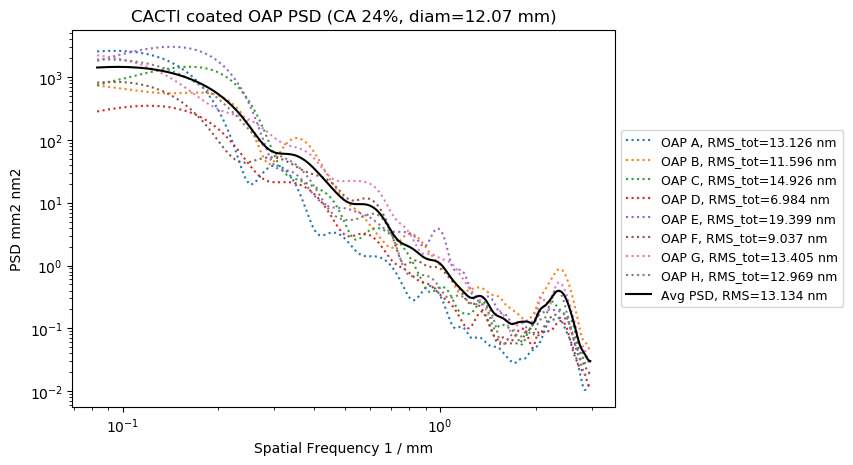

In [10]:
plt.figure(figsize=[7,5], dpi=100)
for obj in oap:
    plt.loglog(obj.k_radial.value, obj.psd_radial_cal.value, ':', label='{0}, RMS_tot={1:.3f}'.format(obj.surf_name, obj.rms))
plt.loglog(avg_k_radial.value, avg_psd_radial.value, 'k', label='Avg PSD, RMS={0:.3f}'.format(avg_rms))
plt.xlabel('Spatial Frequency {0}'.format(oap[0].k_radial.unit))
plt.ylabel('PSD {0}'.format(oap[0].psd_radial_cal.unit))
plt.title('CACTI coated OAP PSD (CA {0}%, diam={1:.2f})'.format(new_parms['ca'], diam))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))

### Calculate the RMS at low, mid, high spatial frequency bands.

In [9]:
# Evaluate the rms at low, mid, high spatial frequency 
k_lm = 1/(10*u.mm)
k_mh = 1/(1*u.mm)

print('RMS calculations')
print('{0:>7} | {1:^9.3} | {2:^10.3} | {3:^8.4} | {4:^10.5}'.format('optic', 'low', 'mid', 'high', 'total'))
for obj in oap:
    rms_low = obj.calc_psd_rms(tgt_low=obj.k_min, tgt_high=k_lm, pwr_opt=obj.psd_cal)
    rms_mid = obj.calc_psd_rms(tgt_low=k_lm, tgt_high=k_mh, pwr_opt=obj.psd_cal)
    print('{0:>7} | {1:6.3f} | {2:7.3f} | {3:.3f} | {4:6.3f}'.format(obj.surf_name, rms_low, rms_mid, obj.rms_h, obj.rms))

# print average one
print('{0:>7} | {1:6.3f} | {2:7.3f} | {3:.3f} | {4:6.3f}'.format('avg PSD', avg_rms_low, avg_rms_mid, avg_rms_high, avg_rms))

RMS calculations
  optic |    low    |    mid     |   high   |   total   
  OAP A |  5.144 nm |  12.009 nm | 1.273 nm | 13.126 nm
  OAP B |  2.654 nm |  10.895 nm | 2.955 nm | 11.596 nm
  OAP C |  2.923 nm |  14.518 nm | 1.864 nm | 14.926 nm
  OAP D |  1.766 nm |   6.604 nm | 1.428 nm |  6.984 nm
  OAP E |  4.582 nm |  18.709 nm | 2.305 nm | 19.399 nm
  OAP F |  2.908 nm |   8.380 nm | 1.727 nm |  9.037 nm
  OAP G |  4.592 nm |  12.349 nm | 2.473 nm | 13.405 nm
  OAP H |  4.388 nm |  12.051 nm | 1.928 nm | 12.969 nm
avg PSD |  3.830 nm |  12.357 nm | 2.267 nm | 13.134 nm
